# Pet Adoption Speed Prediction

## Contents

* [Preprocessing](#preprocessing)
    * [Basic Preprocessing](#basic-prepro)
    * [Description Processing](#description)
        * [Google NLP API](#gnlp)
        * [Topic modeling](#topicmd)
            * [LDA](#lda)
            * [NMF](#nmf)
            * [Bigram LDA](#bigramlda)
    * [Photo Processing](#photo)
        * [Google Computer Vision API](#cv)
* [EDA](#eda)
    * [Target analysis - Adoption Speed](#target)
    * [Categorical feature analysis](#categorical)
    * [Numerical feature analysis](#numerical)
* [Preprocessing for ML](#mlprocessing)
    * [Missing values](#nan)
    * [Scaling](#scaling)
    * [String2Index - Encoding](#encoding)
* [Moden Selection](#model)
    * [Decision Tree](#decisiontree)
    * [SVM](#SVM)
    * [KNN](#KNN)
    * [Naive Bayes Classifier](#NB)
    * [Random Forest](#RF)
    * [XGBoost](#xgb)
* [Grid Search](#grid)

## Preprocessing <a class="anchor" id="preprocessing"></a>

### Import Libraries

In [2]:
# standard libraries
import pandas as pd
pd.set_option('display.max_columns', None) 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

In [2]:
# helper libraries
import os
from zipfile import ZipFile
import json
import random
from nltk.corpus import stopwords
import re

### Read data & Preprocessing <a class="anchor" id="basic-prepro"></a>

In [3]:
# open .zip in memory
with ZipFile('train.zip') as myzip:
    print(myzip.printdir())
    with myzip.open('train.csv') as myfile:
        train = pd.read_csv(myfile)

File Name                                             Modified             Size
train.csv                                      2018-12-26 19:17:22      6690166
None


In [4]:
train.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


In [5]:
train.describe(include='all')

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
count,14993.000000,13736,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993,14993.000000,14981,14993,14993.000000,14993.000000
unique,NaN,9060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5595,NaN,14032,14993,NaN,NaN
top,NaN,Baby,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fa90fa5b1ee11c86938398b60abc32cb,NaN,For Adoption,4771e1226,NaN,NaN
freq,NaN,66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,459,NaN,164,1,NaN,NaN
mean,1.457614,NaN,10.452078,265.272594,74.009738,1.776162,2.234176,3.222837,1.882012,1.862002,1.467485,1.731208,1.558727,1.914227,1.036617,1.576069,21.259988,41346.028347,NaN,0.056760,NaN,NaN,3.889215,2.516441
std,0.498217,NaN,18.155790,60.056818,123.011575,0.681592,1.745225,2.742562,2.984086,0.547959,0.599070,0.667649,0.695817,0.566172,0.199535,1.472477,78.414548,32.444153,NaN,0.346185,NaN,NaN,3.487810,1.177265
min,1.000000,NaN,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000
25%,1.000000,NaN,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,NaN,0.000000,NaN,NaN,2.000000,2.000000
50%,1.000000,NaN,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,NaN,0.000000,NaN,NaN,3.000000,2.000000
75%,2.000000,NaN,12.000000,307.000000,179.000000,2.000000,3.000000,6.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,NaN,0.000000,NaN,NaN,5.000000,4.000000


In [6]:
[file for file in os.listdir() if '.csv' in file]

['breed_labels.csv',
 'color_labels.csv',
 'preprocessed_train.csv',
 'state_labels.csv']

In [7]:
breed_labels = pd.read_csv('breed_labels.csv', dtype=str)
breed_labels.head()

,BreedID,Type,BreedName
0,1,1,Affenpinscher
1,2,1,Afghan Hound
2,3,1,Airedale Terrier
3,4,1,Akbash
4,5,1,Akita


In [8]:
breed_labels.describe()
# BreedID is unique key even when dogs and cats are put together

,BreedID,Type,BreedName
count,307,307,307
unique,307,2,307
top,115,1,Pixie-Bob
freq,1,241,1


In [9]:
color_labels = pd.read_csv('color_labels.csv', dtype=str)
color_labels.head()

,ColorID,ColorName
0,1,Black
1,2,Brown
2,3,Golden
3,4,Yellow
4,5,Cream


In [10]:
state_labels = pd.read_csv('state_labels.csv', dtype=str)
state_labels.head()

,StateID,StateName
0,41336,Johor
1,41325,Kedah
2,41367,Kelantan
3,41401,Kuala Lumpur
4,41415,Labuan


The raw train data uses index numbers (1, 2, 3..) to show categorical columns. To better read and interpret, I am going to convert most of them to texts. The following is from the dataset description:
* Type - Type of animal (1 = Dog, 2 = Cat)
* Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
* MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
* FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
* AdoptionSpeed - Categorical speed of adoption. Lower is faster. 

In [12]:
train['Type'] = train['Type'].replace({1:'Dog', 2:'Cat'})
train['Gender'].replace({1:'Male', 2:'Female', 3: 'Mixed'}, inplace=True)
train['MaturitySize'].replace({1 : 'Small', 2 : 'Medium', 3 : 'Large', 4 : 'Extra Large', 0 : 'Not Specified'}, inplace=True)
train['FurLength'].replace({1 : 'Short', 2 : 'Medium', 3 : 'Long', 0 : 'Not Specified'}, inplace=True)
train['Vaccinated'].replace({1 : 'Yes', 2 : 'No', 3 : 'Not Sure'}, inplace=True)
train['Dewormed'].replace({1 : 'Yes', 2 : 'No', 3 : 'Not Sure'}, inplace=True)
train['Sterilized'].replace({1 : 'Yes', 2 : 'No', 3 : 'Not Sure'}, inplace=True)
train['Health'].replace({1 : 'Healthy', 2 : 'Minor Injury', 3 : 'Serious Injury', 0 : 'Not Specified'}, inplace=True)

# transform label to categorical 
train['AdoptionSpeed'].replace({0: 'Same Day', 1: 'One Week', 2:'One Month', 3:'2 - 3 Month', 4:'No Adoption'}, inplace=True)
train['AdoptionSpeed'] = pd.Categorical(train['AdoptionSpeed'], ordered=True, categories=['Same Day', 'One Week', 'One Month', '2 - 3 Month', 'No Adoption'])
train['AdoptionSpeed'].value_counts()

No Adoption    4197
One Month      4037
2 - 3 Month    3259
One Week       3090
Same Day        410
Name: AdoptionSpeed, dtype: int64

In [13]:
for col in ['Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'State']:
    train[col] = train[col].astype(str)

In [14]:
mapbreed = breed_labels[['BreedID', 'BreedName']].set_index('BreedID').to_dict()['BreedName']

mapcolor = color_labels[['ColorID', 'ColorName']].set_index('ColorID').to_dict()['ColorName']

mapstate = state_labels[['StateID', 'StateName']].set_index('StateID').to_dict()['StateName']

In [15]:
train['Breed1'] = train['Breed1'].replace(mapbreed)
train['Breed2'] = train['Breed2'].replace(mapbreed)
train['Color1'] = train['Color1'].replace(mapcolor)
train['Color2'] = train['Color2'].replace(mapcolor)
train['Color3'] = train['Color3'].replace(mapcolor)
train['State'] = train['State'].replace(mapstate)

In [16]:
train.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,Cat,Nibble,3,Tabby,0,Male,Black,White,0,Small,Short,No,No,No,Healthy,1,100,Selangor,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,One Month
1,Cat,No Name Yet,1,Domestic Medium Hair,0,Male,Black,Brown,0,Medium,Medium,Not Sure,Not Sure,Not Sure,Healthy,1,0,Kuala Lumpur,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,Same Day
2,Dog,Brisco,1,Mixed Breed,0,Male,Brown,White,0,Medium,Medium,Yes,Yes,No,Healthy,1,0,Selangor,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,2 - 3 Month
3,Dog,Miko,4,Mixed Breed,0,Female,Black,Brown,0,Medium,Short,Yes,Yes,No,Healthy,1,150,Kuala Lumpur,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,One Month
4,Dog,Hunter,1,Mixed Breed,0,Male,Black,0,0,Medium,Short,No,No,No,Healthy,1,0,Selangor,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,One Month


In [17]:
train.isnull().sum()

Type                0
Name             1257
Age                 0
Breed1              0
Breed2              0
Gender              0
Color1              0
Color2              0
Color3              0
MaturitySize        0
FurLength           0
Vaccinated          0
Dewormed            0
Sterilized          0
Health              0
Quantity            0
Fee                 0
State               0
RescuerID           0
VideoAmt            0
Description        12
PetID               0
PhotoAmt            0
AdoptionSpeed       0
dtype: int64

The dataset is very clean with only 12 pets not having description. A thousand pets without names are normal as they are waiting for adoption.

In [18]:
train.describe()

,Age,Quantity,Fee,VideoAmt,PhotoAmt
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,10.452078,1.576069,21.259988,0.056760,3.889215
std,18.155790,1.472477,78.414548,0.346185,3.487810
min,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,0.000000,0.000000,2.000000
50%,3.000000,1.000000,0.000000,0.000000,3.000000
75%,12.000000,1.000000,0.000000,0.000000,5.000000
max,255.000000,20.000000,3000.000000,8.000000,30.000000


In [19]:
train.describe(include=['O'])

,Type,Name,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,State,RescuerID,Description,PetID
count,14993,13736,14993,14993,14993,14993,14993,14993,14993,14993,14993,14993,14993,14993,14993,14993,14981,14993
unique,2,9060,176,135,3,7,7,6,4,3,3,3,3,3,14,5595,14032,14993
top,Dog,Baby,Mixed Breed,0,Female,Black,0,0,Medium,Short,No,Yes,No,Healthy,Selangor,fa90fa5b1ee11c86938398b60abc32cb,For Adoption,4771e1226
freq,8132,66,5927,10762,7277,7427,4471,10604,10305,8808,7227,8397,10077,14478,8714,459,164,1


### Description Processing <a class="anchor" id="description"></a>

#### Google's Sentiment API <a class="anchor" id="gnlp"></a>

In [20]:
sentiment = train[['PetID', 'Description']].set_index('PetID')
sentiment.head()

,Description
PetID,
86e1089a3,Nibble is a 3+ month old ball of cuteness. He ...
6296e909a,I just found it alone yesterday near my apartm...
3422e4906,Their pregnant mother was dumped by her irresp...
5842f1ff5,"Good guard dog, very alert, active, obedience ..."
850a43f90,This handsome yet cute boy is up for adoption....


In [21]:
sentiment['docsentiment-magnitude'] = None
sentiment['docsentiment-score'] = None
sentiment['top entity'] = None

In [22]:
with ZipFile('train_sentiment.zip') as myzip:
    for file in myzip.namelist():
        petid = file.replace('.json', '')
        api = json.load(myzip.open(file))
        sentiment.loc[petid, 'docsentiment-magnitude'] = api['documentSentiment']['magnitude']
        sentiment.loc[petid, 'docsentiment-score'] = api['documentSentiment']['score']
        sentiment.loc[petid, 'top entity'] = api['entities'][0]['name'] if len(api['entities'])>0 else None
sentiment.head()

,Description,docsentiment-magnitude,docsentiment-score,top entity
PetID,,,,
86e1089a3,Nibble is a 3+ month old ball of cuteness. He ...,2.4,0.3,Nibble
6296e909a,I just found it alone yesterday near my apartm...,0.7,-0.2,apartment
3422e4906,Their pregnant mother was dumped by her irresp...,3.7,0.2,mother
5842f1ff5,"Good guard dog, very alert, active, obedience ...",0.9,0.9,guard dog
850a43f90,This handsome yet cute boy is up for adoption....,3.7,0.6,boy


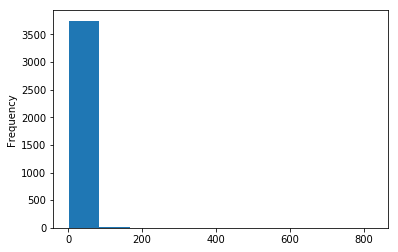

In [37]:
# Way too many disperse top entities
sentiment['top entity'].value_counts()
sentiment['top entity'] = [str(entity).lower() for entity in sentiment['top entity']]
sentiment['top entity'].value_counts().plot(kind='hist', bins=10)

In [43]:
entity_count = sentiment['top entity'].value_counts().reset_index(name='count')
entity_count

,index,count
0,none,825
1,puppy,780
2,kitten,695
3,dog,476
4,puppies,475
5,kittens,472
6,cat,425
7,adoption,358
8,girl,238
9,home,216


In [56]:
top_entity = set(entity_count.loc[entity_count['count']>80, 'index'])
top_entity

{'adopters',
 'adoption',
 'boy',
 'cat',
 'cats',
 'dog',
 'friend',
 'girl',
 'home',
 'kitten',
 'kittens',
 'kitty',
 'mother',
 'name',
 'none',
 'owner',
 'pup',
 'puppies',
 'puppy',
 'pups',
 'siblings'}

In [64]:
sentiment['top entity'] = sentiment['top entity'].apply(lambda x: x if x in top_entity else 'none')
sentiment.head()

,Description,docsentiment-magnitude,docsentiment-score,top entity
PetID,,,,
86e1089a3,Nibble is a 3+ month old ball of cuteness. He ...,2.4,0.3,none
6296e909a,I just found it alone yesterday near my apartm...,0.7,-0.2,none
3422e4906,Their pregnant mother was dumped by her irresp...,3.7,0.2,mother
5842f1ff5,"Good guard dog, very alert, active, obedience ...",0.9,0.9,none
850a43f90,This handsome yet cute boy is up for adoption....,3.7,0.6,boy


In [65]:
#sentiment_d = sentiment.drop('Description', axis=1)
train = train.merge(sentiment.drop('Description', axis=1).reset_index())
train.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,docsentiment-magnitude,docsentiment-score,top entity
0,Cat,Nibble,3,Tabby,0,Male,Black,White,0,Small,Short,No,No,No,Healthy,1,100,Selangor,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,One Month,2.4,0.3,none
1,Cat,No Name Yet,1,Domestic Medium Hair,0,Male,Black,Brown,0,Medium,Medium,Not Sure,Not Sure,Not Sure,Healthy,1,0,Kuala Lumpur,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,Same Day,0.7,-0.2,none
2,Dog,Brisco,1,Mixed Breed,0,Male,Brown,White,0,Medium,Medium,Yes,Yes,No,Healthy,1,0,Selangor,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,2 - 3 Month,3.7,0.2,mother
3,Dog,Miko,4,Mixed Breed,0,Female,Black,Brown,0,Medium,Short,Yes,Yes,No,Healthy,1,150,Kuala Lumpur,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,One Month,0.9,0.9,none
4,Dog,Hunter,1,Mixed Breed,0,Male,Black,0,0,Medium,Short,No,No,No,Healthy,1,0,Selangor,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,One Month,3.7,0.6,boy


So far, I have included Google's NLP api's **sentiment ratings (magnitude and score)**, as well as **top 1 entity** to data. But I am curious if longer descriptions and what kind of pitch/tone would bring up more sympathies from potential adopters. So below I will implement a simple word count and NMF and LDA topic modelings.

In [66]:
# word count
train['word_count'] = train['Description'].apply(lambda x: 0 if str(x)=='nan' else len([word for word in x.split()])) 
train['word_count'].describe()

count    14993.000000
mean        62.953645
std         69.298493
min          0.000000
25%         21.000000
50%         44.000000
75%         81.000000
max       1257.000000
Name: word_count, dtype: float64

#### Topic Modeling <a class="anchor" id="topicmd"></a>

In [67]:
train['Description'][7]

'Siu Pak just give birth on 13/6/10 to 6puppies. Interested pls call or sms me. Left 2female puppies on 2/7/10'

In [70]:
# lowercase and strip punctuation and multiple spaces
train['Descr_post'] = train['Description'].apply(lambda x: re.sub(r'[^\d\w\/]+\s*', ' ', str(x).lower()))
train['Descr_post'][7]

'siu pak just give birth on 13/6/10 to 6puppies interested pls call or sms me left 2female puppies on 2/7/10'

In [71]:
# remove stopwords
train['Descr_post'] = train['Descr_post'].apply(lambda x: ' '.join([word for word in str(x).split() \
                                                                    if word not in stopwords.words('english')]))
train['Descr_post'][7]

0    nibble 3 month old ball cuteness energetic pla...
1    found alone yesterday near apartment shaking b...
2    pregnant mother dumped irresponsible owner roa...
3    good guard dog alert active obedience waiting ...
4    handsome yet cute boy adoption playful pal see...
Name: Descr_post, dtype: object

#### Prepare corpus

In [73]:
documents = [doc for doc in train['Descr_post'] if str(doc) != 'nan']

In [74]:
len(documents)

14981

In [75]:
documents[:3]

['nibble 3 month old ball cuteness energetic playful rescued couple cats months ago could get neutered time clinic fully scheduled result little kitty enough space funds care cats household looking responsible people take nibble care',
 'found alone yesterday near apartment shaking bring home provide temporary care',
 'pregnant mother dumped irresponsible owner roadside near shops subang jaya gave birth roadside healthy adorable puppies already dewormed vaccinated ready go home tying caging long hours guard dogs however acceptable cage tie precautionary purposes interested adopt pls call']

Here I quickly apply NMF and LDA clustering using 1000 features and 20 topics, and see if the resulted topics are good. Although NMF's 20 topics look nice, it is harder to determine what is the optimal number of topics as the fit transformed matrix, W, does not sum up to 1. On the other hand, LDA returns probabilistic distribution and has score/performance metrix, which we can use GridSearch to find the optimum.

In [76]:
# NMF, LDA clustering

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

def display_topics(model, feature_names, no_top_words):
    print(model, ":")
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" + ".join([feature_names[i]\
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

no_topics = 20

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda, tf_feature_names, no_top_words)

NMF(alpha=0.1, beta_loss='frobenius', init='nndsvd', l1_ratio=0.5, max_iter=200,
    n_components=20, random_state=1, shuffle=False, solver='cd', tol=0.0001,
    verbose=0) :
Topic 0:
love like loves cats care time play family little house
Topic 1:
adoption fee free available fees ready open rm visit pj
Topic 2:
pls commitment adopt compulsory spay lovely rachel interested looking contact
Topic 3:
dog guard dogs house breed stray alert watch bark birth
Topic 4:
puppy adorable lovely adopt born animal help lovers hope looking
Topic 5:
puppies birth mother gave dogs rescued adopted stray female help
Topic 6:
cat litter cats indoor stray lover trained birth food house
Topic 7:
cute adorable little kitty naughty really kind adopt smart super
Topic 8:
kitten food litter trained little mother eat stray box wet
Topic 9:
dan saya kucing dia yang di untuk ni boleh manja
Topic 10:
old female male months black white month breed dewormed mixed
Topic 11:
kittens mother birth gave cats adopted stray

/Users/wandajuan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


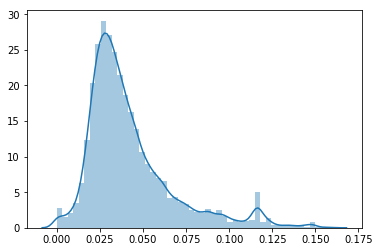

In [77]:
sns.distplot(nmf.transform(tfidf).max(axis=1))

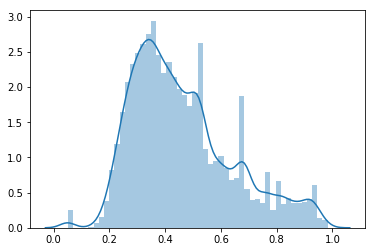

In [78]:
sns.distplot(lda.transform(tf).max(axis=1))

#### LDA <a class='anchor' id='lda'></a>

In [79]:
# Grid Search (https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/)
from sklearn.model_selection import GridSearchCV
search_params = {'n_components': [10, 15, 20, 25, 30]}
model = GridSearchCV(lda, param_grid=search_params)
model.fit(tf)

/Users/wandajuan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='online',
                                                 learning_offset=50.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=5,
                                                 mean_change_tol=0.001,
                                                 n_components=20, n_jobs=None,
                                                 perp_tol=0.1, random_state=0,
                                                 topic_word_prior=None,
                                                 total_samples=1000000.0,
             

In [80]:
best_lda_model = model.best_estimator_
print("Best Model's Parameters: ", model.best_params_)
print("Log likelihood score: ", model.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(tf))

Best Model's Parameters:  {'n_components': 10}
Log likelihood score:  -686286.6463284383
Model Perplexity:  475.025476041098


In [134]:
lda_output = best_lda_model.transform(tf)

In [93]:
lda_output.shape

(14981, 10)

In [135]:
doc2topic = pd.DataFrame(np.round(lda_output, 2), \
             columns=["Topic"+str(i) for i in range(best_lda_model.n_components)])

In [110]:
best_lda_model.components_.shape[0] # ratings for 10 topics with 1000 features


10

In [136]:
topic_dict = {}
for topic_idx, topic in enumerate(best_lda_model.components_):
    topic_dict[topic_idx] = ' '.join([tf_feature_names[feature_idx] for feature_idx in topic.argsort()[:-best_lda_model.n_components-1:-1]])
print('LDA topics')
topic_dict

LDA topics


{0: 'playful active friendly cat trained good loving toilet pup cute',
 1: 'kitten old playful kittens healthy months vaccinated dewormed adoption active',
 2: 'home puppies contact puppy looking adopt interested pls loving forever',
 3: 'dog home good owner dogs family love loving friendly loves',
 4: 'adopt puppy interested adopters contact open whatsapp shelter adoption vaccinate',
 5: 'saya dan kucing dia yang di ni untuk yg boleh',
 6: 'food like little loves girl play eat love people kitty',
 7: 'adoption adopter vaccination neutering fee medical vet cost spaying provide',
 8: 'female male breed black old white adoption brown mixed location',
 9: 'cat kittens care home cats house adopt kitten new need'}

In [137]:
doc2topic['dominant_topic'] = np.argmax(doc2topic.values, axis=1)
doc2topic

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
0,0.00,0.20,0.00,0.00,0.00,0.00,0.37,0.00,0.00,0.41,9
1,0.01,0.01,0.59,0.01,0.01,0.01,0.01,0.01,0.01,0.32,2
2,0.00,0.16,0.47,0.35,0.00,0.00,0.00,0.00,0.00,0.00,2
3,0.52,0.01,0.20,0.23,0.01,0.01,0.01,0.01,0.01,0.01,0
4,0.23,0.00,0.35,0.00,0.13,0.00,0.16,0.00,0.10,0.00,2
5,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.85,9
6,0.05,0.00,0.16,0.00,0.00,0.00,0.00,0.00,0.00,0.76,9
7,0.01,0.01,0.46,0.01,0.01,0.01,0.01,0.27,0.20,0.01,2
8,0.45,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.44,0
9,0.23,0.01,0.28,0.01,0.01,0.01,0.29,0.01,0.01,0.16,6


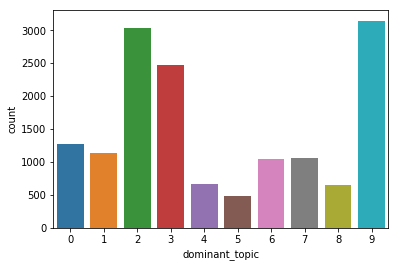

In [138]:
sns.countplot(doc2topic['dominant_topic'])

#### NMF <a class='anchor' id='nmf'></a>

In [81]:
model_nmf = GridSearchCV(lda, param_grid=search_params)
model_nmf.fit(tfidf)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='online',
                                                 learning_offset=50.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=5,
                                                 mean_change_tol=0.001,
                                                 n_components=20, n_jobs=None,
                                                 perp_tol=0.1, random_state=0,
                                                 topic_word_prior=None,
                                                 total_samples=1000000.0,
             

In [91]:
best_nmf_model = model_nmf.best_estimator_
print("Best Model's Parameters: ", model_nmf.best_params_)
print("Log likelihood score: ", model_nmf.best_score_)
print("Model Perplexity: ", best_nmf_model.perplexity(tfidf))

Best Model's Parameters:  {'n_components': 10}
Log likelihood score:  -142894.1166478565
Model Perplexity:  1373.0816791235643


In [100]:
nmf_output = best_nmf_model.transform(tfidf)
nmf_output.shape #(14981, 10)
doc2topic_nmf = pd.DataFrame(np.round(nmf_output, 2), \
                            columns=['Topic '+str(i) for i in range(best_nmf_model.n_components)])

doc2topic_nmf['dominant_topic'] = np.argmax(doc2topic_nmf.values, axis=1)
doc2topic_nmf

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,dominant_topic
0,0.02,0.02,0.02,0.64,0.02,0.02,0.22,0.02,0.02,0.02,3
1,0.03,0.03,0.76,0.03,0.03,0.03,0.03,0.03,0.03,0.03,2
2,0.02,0.54,0.32,0.02,0.02,0.02,0.02,0.02,0.02,0.02,1
3,0.02,0.02,0.60,0.02,0.02,0.02,0.02,0.02,0.21,0.02,2
4,0.02,0.02,0.02,0.02,0.31,0.02,0.29,0.02,0.27,0.02,4
5,0.03,0.03,0.72,0.03,0.03,0.03,0.03,0.03,0.03,0.03,2
6,0.02,0.02,0.83,0.02,0.02,0.02,0.02,0.02,0.02,0.02,2
7,0.03,0.03,0.31,0.03,0.03,0.03,0.03,0.03,0.03,0.46,9
8,0.31,0.03,0.45,0.03,0.03,0.03,0.03,0.03,0.03,0.03,2
9,0.02,0.02,0.62,0.02,0.02,0.02,0.21,0.02,0.02,0.02,2


In [139]:
topic_dict = {}
for topic_idx, topic in enumerate(best_nmf_model.components_):
    topic_dict[topic_idx] = ' '.join([tfidf_feature_names[feature_idx] for feature_idx in topic.argsort()[:-best_nmf_model.n_components-1:-1]])
print('NMF topics')
topic_dict

NMF topics


{0: 'cute playful active friendly adorable healthy whatsapp 30pm fat oreo',
 1: 'pls home contact interested spay commitment looking puppy compulsory adopt',
 2: 'home kittens puppies adopt cat care mother house need kitten',
 3: 'dog home good loves love owner loving dogs family friendly',
 4: 'white black female breed adoption male old cat brown kittens',
 5: 'adoption dan kucing saya dia yang dog di sangat manja',
 6: 'trained loves cat playful litter kitten play toilet active likes',
 7: 'angel kids loyal handle easy companion number price currently friendly',
 8: 'home puppy good dog looking rescued loving smart adopter forever',
 9: 'contact ms interested kindly location alam shah jaya adopting mths'}

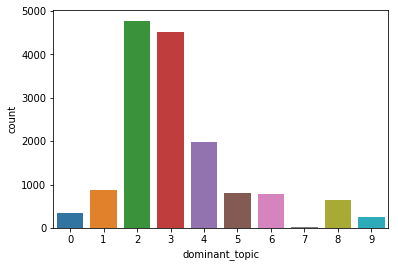

In [140]:
sns.countplot(doc2topic_nmf['dominant_topic'])

From top 10 words in each topic generated by LDA and NMF, it looks like NMF messes up more as the most frequent topic (topic 2) in NMF contains both kittens and puppies. Therefore, I consider it is harder to generate insights and LDA. The following I am adding the dominant topic provided by LDA to the main data.

In [141]:
train[train['Description'].isnull()].index

Int64Index([96, 605, 1098, 2109, 4218, 4904, 6041, 8674, 10272, 11365, 12713,
            14809],
           dtype='int64')

In [143]:
df = train.loc[~train['Description'].isnull()].reset_index()
df

,index,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,docsentiment-magnitude,docsentiment-score,top entity,word_count,Descr_post
0,0,Cat,Nibble,3,Tabby,0,Male,Black,White,0,Small,Short,No,No,No,Healthy,1,100,Selangor,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,One Month,2.4,0.3,none,69,nibble 3 month old ball cuteness energetic pla...
1,1,Cat,No Name Yet,1,Domestic Medium Hair,0,Male,Black,Brown,0,Medium,Medium,Not Sure,Not Sure,Not Sure,Healthy,1,0,Kuala Lumpur,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,Same Day,0.7,-0.2,none,23,found alone yesterday near apartment shaking b...
2,2,Dog,Brisco,1,Mixed Breed,0,Male,Brown,White,0,Medium,Medium,Yes,Yes,No,Healthy,1,0,Selangor,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,2 - 3 Month,3.7,0.2,mother,69,pregnant mother dumped irresponsible owner roa...
3,3,Dog,Miko,4,Mixed Breed,0,Female,Black,Brown,0,Medium,Short,Yes,Yes,No,Healthy,1,150,Kuala Lumpur,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,One Month,0.9,0.9,none,25,good guard dog alert active obedience waiting ...
4,4,Dog,Hunter,1,Mixed Breed,0,Male,Black,0,0,Medium,Short,No,No,No,Healthy,1,0,Selangor,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,One Month,3.7,0.6,boy,81,handsome yet cute boy adoption playful pal see...
5,5,Cat,NaN,3,Domestic Short Hair,0,Female,Cream,Gray,0,Medium,Short,No,No,No,Healthy,1,0,Selangor,22fe332bf9c924d4718005891c63fbed,0,This is a stray kitten that came to my house. ...,d24c30b4b,2.0,One Month,0.2,0,kitten,18,stray kitten came house feeding cannot keep
6,6,Cat,BULAT,12,Domestic Long Hair,Domestic Long Hair,Male,Black,0,0,Medium,Long,No,No,Not Sure,Healthy,1,300,Selangor,1e0b5a458b5b77f5af581d57ebf570b3,0,anyone within the area of ipoh or taiping who ...,1caa6fcdb,3.0,One Week,0.5,0.2,none,78,anyone within area ipoh taiping interested ado...
7,7,Dog,Siu Pak & Her 6 Puppies,0,Mixed Breed,0,Female,Black,Brown,White,Medium,Short,No,No,No,Healthy,6,0,Selangor,1fba5f6e5480946254590d48f9c5198d,0,Siu Pak just give birth on 13/6/10 to 6puppies...,97aa9eeac,9.0,2 - 3 Month,0.9,0.1,none,20,siu pak give birth 13/6/10 6puppies interested...
8,8,Cat,NaN,2,Domestic Medium Hair,0,Female,Gray,0,0,Medium,Medium,No,No,No,Healthy,1,0,Selangor,d8af7afece71334473575c9f70daf00d,0,"healthy and active, feisty kitten found in nei...",c06d167ca,6.0,One Week,0.5,0.1,none,13,healthy active feisty kitten found neighbours ...
9,9,Cat,Kitty,12,Domestic Medium Hair,0,Female,Black,White,0,Medium,Medium,Not Sure,Not Sure,Not Sure,Healthy,1,0,Selangor,1f3f36e4b18e94855b3e88af0852fdc4,0,"Very manja and gentle stray cat found, we woul...",7a0942d61,2.0,No Adoption,1.1,0.2,cat,45,manja gentle stray cat found would really like...


In [144]:
df = df.merge(doc2topic, left_index=True, right_index=True)
df

,index,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,docsentiment-magnitude,docsentiment-score,top entity,word_count,Descr_post,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
0,0,Cat,Nibble,3,Tabby,0,Male,Black,White,0,Small,Short,No,No,No,Healthy,1,100,Selangor,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,One Month,2.4,0.3,none,69,nibble 3 month old ball cuteness energetic pla...,0.00,0.20,0.00,0.00,0.00,0.00,0.37,0.00,0.00,0.41,9
1,1,Cat,No Name Yet,1,Domestic Medium Hair,0,Male,Black,Brown,0,Medium,Medium,Not Sure,Not Sure,Not Sure,Healthy,1,0,Kuala Lumpur,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,Same Day,0.7,-0.2,none,23,found alone yesterday near apartment shaking b...,0.01,0.01,0.59,0.01,0.01,0.01,0.01,0.01,0.01,0.32,2
2,2,Dog,Brisco,1,Mixed Breed,0,Male,Brown,White,0,Medium,Medium,Yes,Yes,No,Healthy,1,0,Selangor,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,2 - 3 Month,3.7,0.2,mother,69,pregnant mother dumped irresponsible owner roa...,0.00,0.16,0.47,0.35,0.00,0.00,0.00,0.00,0.00,0.00,2
3,3,Dog,Miko,4,Mixed Breed,0,Female,Black,Brown,0,Medium,Short,Yes,Yes,No,Healthy,1,150,Kuala Lumpur,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,One Month,0.9,0.9,none,25,good guard dog alert active obedience waiting ...,0.52,0.01,0.20,0.23,0.01,0.01,0.01,0.01,0.01,0.01,0
4,4,Dog,Hunter,1,Mixed Breed,0,Male,Black,0,0,Medium,Short,No,No,No,Healthy,1,0,Selangor,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,One Month,3.7,0.6,boy,81,handsome yet cute boy adoption playful pal see...,0.23,0.00,0.35,0.00,0.13,0.00,0.16,0.00,0.10,0.00,2
5,5,Cat,NaN,3,Domestic Short Hair,0,Female,Cream,Gray,0,Medium,Short,No,No,No,Healthy,1,0,Selangor,22fe332bf9c924d4718005891c63fbed,0,This is a stray kitten that came to my house. ...,d24c30b4b,2.0,One Month,0.2,0,kitten,18,stray kitten came house feeding cannot keep,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.85,9
6,6,Cat,BULAT,12,Domestic Long Hair,Domestic Long Hair,Male,Black,0,0,Medium,Long,No,No,Not Sure,Healthy,1,300,Selangor,1e0b5a458b5b77f5af581d57ebf570b3,0,anyone within the area of ipoh or taiping who ...,1caa6fcdb,3.0,One Week,0.5,0.2,none,78,anyone within area ipoh taiping interested ado...,0.05,0.00,0.16,0.00,0.00,0.00,0.00,0.00,0.00,0.76,9
7,7,Dog,Siu Pak & Her 6 Puppies,0,Mixed Breed,0,Female,Black,Brown,White,Medium,Short,No,No,No,Healthy,6,0,Selangor,1fba5f6e5480946254590d48f9c5198d,0,Siu Pak just give birth on 13/6/10 to 6puppies...,97aa9eeac,9.0,2 - 3 Month,0.9,0.1,none,20,siu pak give birth 13/6/10 6puppies interested...,0.01,0.01,0.46,0.01,0.01,0.01,0.01,0.27,0.20,0.01,2
8,8,Cat,NaN,2,Domestic Medium Hair,0,Female,Gray,0,0,Medium,Medium,No,No,No,Healthy,1,0,Selangor,d8af7afece71334473575c9f70daf00d,0,"healthy and active, feisty kitten found in nei...",c06d167ca,6.0,One Week,0.5,0.1,none,13,healthy active feisty kitten found neighbours ...,0.45,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.44,0
9,9,Cat,Kitty,12,Domestic Medium Hair,0,Female,Black,White,0,Medium,Medium,Not Sure,Not Sure,Not Sure,Healthy,1,0,Selangor,1f3f36e4b18e94855b3e88af0852fdc4,0,"Very manja and gentle stray cat found, we woul...",7a0942d61,2.0,No Adoption,1.1,0.2,cat,45,manja gentle stray cat found would really like...,0.23,0.01,0.28,0.01,0.01,0.01,0.29,0.01,0.01,0.16,6


In [145]:
tmp = pd.DataFrame(df['dominant_topic'], index=df['index'])
tmp

,dominant_topic
index,
0,9.0
1,2.0
2,2.0
3,0.0
4,2.0
5,9.0
6,9.0
7,2.0
8,0.0


In [146]:
train = train.merge(tmp, left_index=True, right_index=True, how='left')
train

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,docsentiment-magnitude,docsentiment-score,top entity,word_count,Descr_post,dominant_topic
0,Cat,Nibble,3,Tabby,0,Male,Black,White,0,Small,Short,No,No,No,Healthy,1,100,Selangor,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,One Month,2.4,0.3,none,69,nibble 3 month old ball cuteness energetic pla...,9.0
1,Cat,No Name Yet,1,Domestic Medium Hair,0,Male,Black,Brown,0,Medium,Medium,Not Sure,Not Sure,Not Sure,Healthy,1,0,Kuala Lumpur,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,Same Day,0.7,-0.2,none,23,found alone yesterday near apartment shaking b...,2.0
2,Dog,Brisco,1,Mixed Breed,0,Male,Brown,White,0,Medium,Medium,Yes,Yes,No,Healthy,1,0,Selangor,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,2 - 3 Month,3.7,0.2,mother,69,pregnant mother dumped irresponsible owner roa...,2.0
3,Dog,Miko,4,Mixed Breed,0,Female,Black,Brown,0,Medium,Short,Yes,Yes,No,Healthy,1,150,Kuala Lumpur,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,One Month,0.9,0.9,none,25,good guard dog alert active obedience waiting ...,0.0
4,Dog,Hunter,1,Mixed Breed,0,Male,Black,0,0,Medium,Short,No,No,No,Healthy,1,0,Selangor,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,One Month,3.7,0.6,boy,81,handsome yet cute boy adoption playful pal see...,2.0
5,Cat,NaN,3,Domestic Short Hair,0,Female,Cream,Gray,0,Medium,Short,No,No,No,Healthy,1,0,Selangor,22fe332bf9c924d4718005891c63fbed,0,This is a stray kitten that came to my house. ...,d24c30b4b,2.0,One Month,0.2,0,kitten,18,stray kitten came house feeding cannot keep,9.0
6,Cat,BULAT,12,Domestic Long Hair,Domestic Long Hair,Male,Black,0,0,Medium,Long,No,No,Not Sure,Healthy,1,300,Selangor,1e0b5a458b5b77f5af581d57ebf570b3,0,anyone within the area of ipoh or taiping who ...,1caa6fcdb,3.0,One Week,0.5,0.2,none,78,anyone within area ipoh taiping interested ado...,9.0
7,Dog,Siu Pak & Her 6 Puppies,0,Mixed Breed,0,Female,Black,Brown,White,Medium,Short,No,No,No,Healthy,6,0,Selangor,1fba5f6e5480946254590d48f9c5198d,0,Siu Pak just give birth on 13/6/10 to 6puppies...,97aa9eeac,9.0,2 - 3 Month,0.9,0.1,none,20,siu pak give birth 13/6/10 6puppies interested...,2.0
8,Cat,NaN,2,Domestic Medium Hair,0,Female,Gray,0,0,Medium,Medium,No,No,No,Healthy,1,0,Selangor,d8af7afece71334473575c9f70daf00d,0,"healthy and active, feisty kitten found in nei...",c06d167ca,6.0,One Week,0.5,0.1,none,13,healthy active feisty kitten found neighbours ...,0.0
9,Cat,Kitty,12,Domestic Medium Hair,0,Female,Black,White,0,Medium,Medium,Not Sure,Not Sure,Not Sure,Healthy,1,0,Selangor,1f3f36e4b18e94855b3e88af0852fdc4,0,"Very manja and gentle stray cat found, we woul...",7a0942d61,2.0,No Adoption,1.1,0.2,cat,45,manja gentle stray cat found would really like...,6.0


#### Bigram LDA <a class='anchor' id='bigramlda'></a>

In [163]:
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2), max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
bigram_tf = bigram_vectorizer.fit_transform(documents)
bigram_feature_names = bigram_vectorizer.get_feature_names()

# tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
# tf = tf_vectorizer.fit_transform(documents)
# tf_feature_names = tf_vectorizer.get_feature_names()

In [166]:
lda_bi = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(bigram_tf)

no_top_words = 10
display_topics(lda_bi, bigram_feature_names, no_top_words)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0) :
Topic 0:
puppies + female + male + dog + pups + dogs + puppy + mother + help + breed
Topic 1:
new + home + new home + years + lover + cat + lovely + years old + adopt + animal
Topic 2:
owner + playful + taking + new owner + trained + active + toilet + new + spca + currently
Topic 3:
kittens + old + months + months old + kitten + mother + cat + month + adoption + birth
Topic 4:
saya + dan + kucing + dia + yang + di + ni + manja + untuk + yg
Topic 5:
cute + caging + adorable + tying + long + adopt + jaya + ho

**Bigram** does not seem to perform any better than unigram so I am skipping further analysis.

### Photo Processing <a class='anchor' id='photo'></a> 

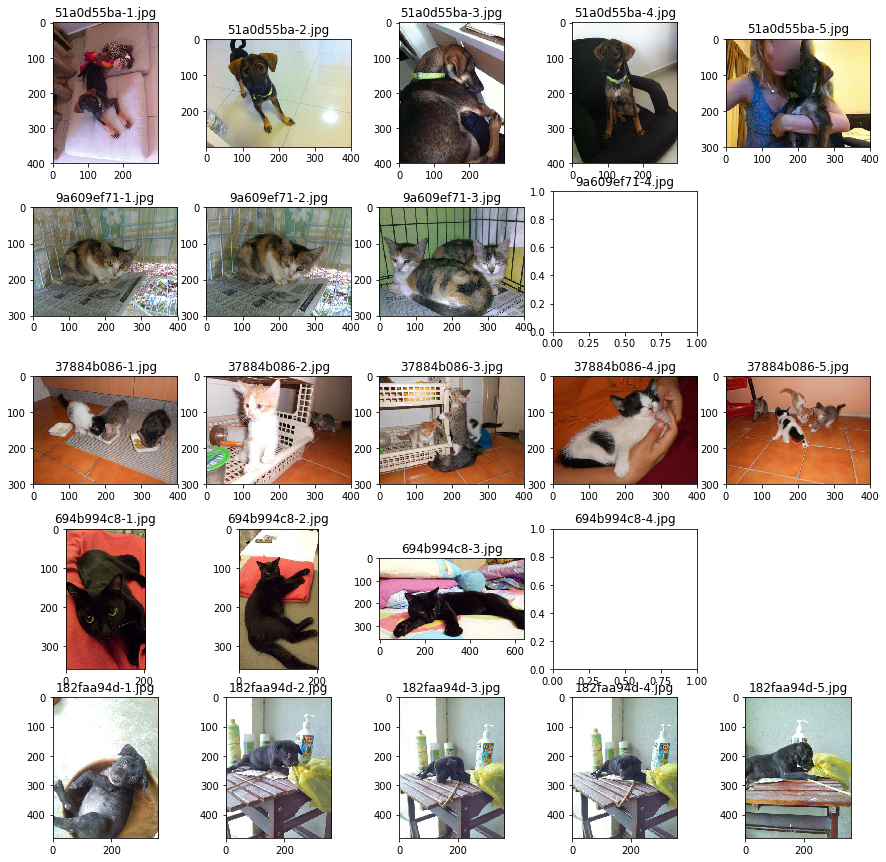

In [167]:
# randomly view 5 pets' first 5 photos
fig = plt.figure(figsize=(15, 15))
cols = 5
rows = 5
with ZipFile('train_images.zip') as my_zip:
    for i in range(5):
        petid = train.loc[train['PhotoAmt']!=0, 'PetID'][random.randint(0, 14652)]
        #print(petid)
        for j in range(5):
            #print('{0}-{1}.jpg'.format(petid, j+1))
            try:
                fig.add_subplot(rows, cols, i*5+j+1)
                plt.title('{0}-{1}.jpg'.format(petid, j+1))
                plt.imshow(mpimg.imread(my_zip.open('{0}-{1}.jpg'.format(petid, j+1))))
            except:
                #print('exception')
                break

## Google Computer Vision API - EntityAnnotation <a class='anchor' id='cv'> </a>

In [168]:
with ZipFile('train_metadata.zip') as myzip:
    metadata_list = myzip.namelist()
    metadata_file = metadata_list[random.randint(1, len(metadata_list))]
    metadata = json.load(myzip.open(metadata_file))
print(metadata_file)
metadata

1b752d78e-4.json


{'labelAnnotations': [{'mid': '/m/0bt9lr',
   'description': 'dog',
   'score': 0.9821529,
   'topicality': 0.9821529},
  {'mid': '/m/0km5c',
   'description': 'german shepherd dog',
   'score': 0.9444403,
   'topicality': 0.9444403},
  {'mid': '/m/01z5f',
   'description': 'dog like mammal',
   'score': 0.9429103,
   'topicality': 0.9429103},
  {'mid': '/m/0kpmf',
   'description': 'dog breed',
   'score': 0.9336039,
   'topicality': 0.9336039},
  {'mid': '/m/02xl47d',
   'description': 'dog breed group',
   'score': 0.7904646,
   'topicality': 0.7904646},
  {'mid': '/m/05zmzn1',
   'description': 'street dog',
   'score': 0.7611755,
   'topicality': 0.7611755},
  {'mid': '/m/04cxnvd',
   'description': 'king shepherd',
   'score': 0.75359726,
   'topicality': 0.75359726},
  {'mid': '/m/0268p8v',
   'description': 'kunming wolfdog',
   'score': 0.7484842,
   'topicality': 0.7484842},
  {'mid': '/m/04n468c',
   'description': 'old german shepherd dog',
   'score': 0.7057021,
   'topica

I randomly looked at a few pet pictures visually as well as read metadata from Google's API. It looks like the metadata does not provide insightful information, other than this is a dog/cat and maybe a rare breed, which we have already known because of the context. The metadata also provides colors in the picture, but we have pet colors in the primary dataset, which is more precise and specific referring to the pet's color, not the background. So I don't think it is needed to incorporate these metadata to the training dataset. Instead, **PhotoAmt** is a good enough indicator showing how visually the list is showing to the potential adopters. 

In [170]:
train.to_csv('preprocessed_train.csv')

## EDA <a class='anchor' id='eda'></a>

In [172]:
### uncomment when skipping previous preprocessing
# train = pd.read_csv('preprocessed_train.csv', \ 
#                    index_col=0, dtype={'dominant_topic': str, 'PhotoAmt': int})

In [175]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14993 entries, 0 to 14992
Data columns (total 30 columns):
Type                      14993 non-null object
Name                      13736 non-null object
Age                       14993 non-null int64
Breed1                    14993 non-null object
Breed2                    14993 non-null object
Gender                    14993 non-null object
Color1                    14993 non-null object
Color2                    14993 non-null object
Color3                    14993 non-null object
MaturitySize              14993 non-null object
FurLength                 14993 non-null object
Vaccinated                14993 non-null object
Dewormed                  14993 non-null object
Sterilized                14993 non-null object
Health                    14993 non-null object
Quantity                  14993 non-null int64
Fee                       14993 non-null int64
State                     14993 non-null object
RescuerID                 1499

### Target Analysis: Adoption Speed <a class='anchor' id='label'></a>

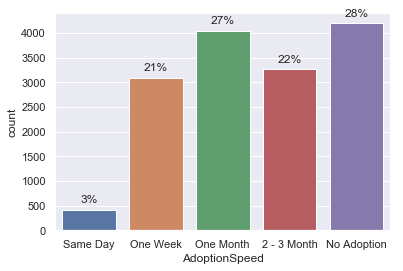

In [201]:
train['AdoptionSpeed'] = pd.Categorical(train['AdoptionSpeed'], ordered=True, categories=['Same Day', 'One Week', 'One Month', '2 - 3 Month', 'No Adoption'])
total_p = len(train['AdoptionSpeed'])

sns.set_style('darkgrid')
ax = sns.countplot(train['AdoptionSpeed'])

for p in ax.patches:
    ax.annotate('{:.0f}%'.format(100*p.get_height()/total_p), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

## Categorical feature analysis <a class='anchor' id='categorical'></a>

In [207]:
cate_col = train.columns[train.dtypes==object]
train.loc[:, cate_col].nunique()

Type                  2
Name               9060
Breed1              176
Breed2              135
Gender                3
Color1                7
Color2                7
Color3                6
MaturitySize          4
FurLength             3
Vaccinated            3
Dewormed              3
Sterilized            3
Health                3
State                14
RescuerID          5595
Description       14032
PetID             14993
top entity           21
Descr_post        13849
dominant_topic       10
dtype: int64

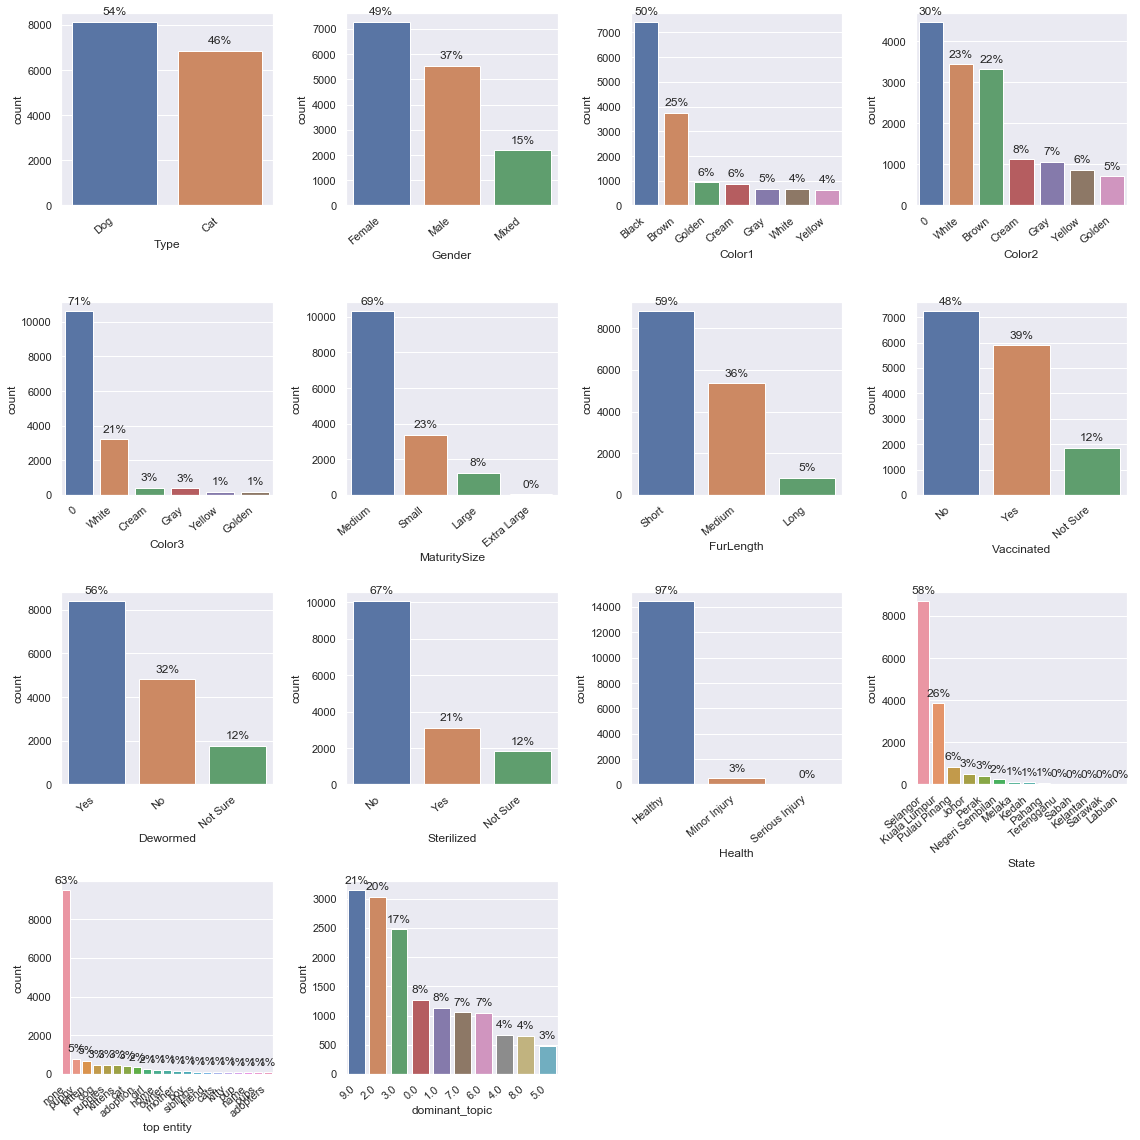

In [211]:
# plot frequency charts only for categorical features that have less than 22 unique values
cols = train.columns[(train.nunique()<22)&(train.dtypes==object)]

plt.figure(figsize=(16, 16))
for i, col in enumerate(cols):
    plt.subplot(4, 4,  i+1)
    ax = sns.countplot(train[col], order=train[col].value_counts().index)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    for p in ax.patches:
        ax.annotate('{:.0f}%'.format(100*p.get_height()/total_p), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    plt.tight_layout()
plt.show()

In [230]:
# clean up Breed
train.loc[train['Breed1']=='0', 'Breed1'] = train.loc[train['Breed1']=='0', 'Breed2']
train.loc[train['Breed1']==train['Breed2'], 'Breed2'] = '0'

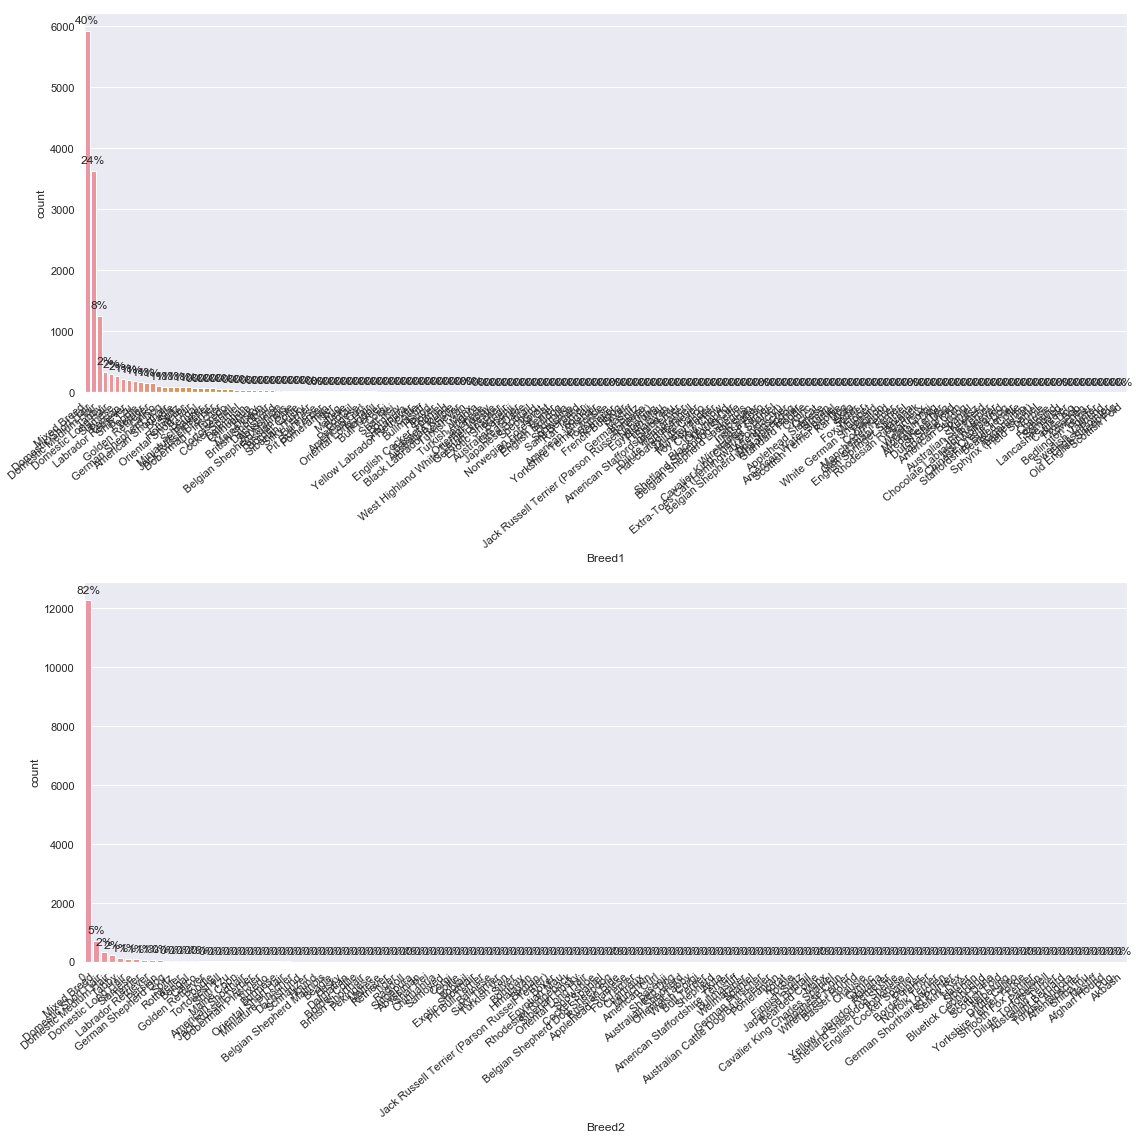

In [231]:
cols = ['Breed1', 'Breed2']
plt.figure(figsize=(16, 16))
for i, col in enumerate(cols):
    plt.subplot(2, 1,  i+1)
    ax = sns.countplot(train[col], order=train[col].value_counts().index)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    for p in ax.patches:
        ax.annotate('{:.0f}%'.format(100*p.get_height()/total_p), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    plt.tight_layout()
plt.show()

In [236]:
train['Breed_cnt'] = train[['Breed1', 'Breed2']].apply(lambda x: 1 if x['Breed2']=='0' else 2, axis=1)

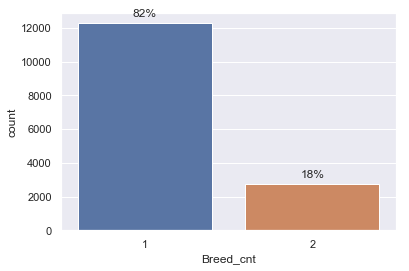

In [239]:
ax= sns.countplot(train['Breed_cnt'])
for p in ax.patches:
    ax.annotate('{:.0f}%'.format(100*p.get_height()/total_p), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [262]:
# check if entrices are consistent
train[['Color1', 'Color2', 'Color3']].drop_duplicates().sort_values(by=['Color1', 'Color2', 'Color3'])

,Color1,Color2,Color3
4,Black,0,0
1,Black,Brown,0
11,Black,Brown,Cream
124,Black,Brown,Golden
210,Black,Brown,Gray
7,Black,Brown,White
305,Black,Brown,Yellow
121,Black,Cream,0
945,Black,Cream,Gray
240,Black,Cream,White


In [269]:
train['color_cnt'] = (train[['Color1', 'Color2', 'Color3']]!='0').sum(axis=1)
train

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,docsentiment-magnitude,docsentiment-score,top entity,word_count,Descr_post,dominant_topic,Breed_cnt,color_cnt
0,Cat,Nibble,3,Tabby,0,Male,Black,White,0,Small,Short,No,No,No,Healthy,1,100,Selangor,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1,One Month,2.4,0.3,none,69,nibble 3 month old ball cuteness energetic pla...,9.0,1,2
1,Cat,No Name Yet,1,Domestic Medium Hair,0,Male,Black,Brown,0,Medium,Medium,Not Sure,Not Sure,Not Sure,Healthy,1,0,Kuala Lumpur,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2,Same Day,0.7,-0.2,none,23,found alone yesterday near apartment shaking b...,2.0,1,2
2,Dog,Brisco,1,Mixed Breed,0,Male,Brown,White,0,Medium,Medium,Yes,Yes,No,Healthy,1,0,Selangor,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7,2 - 3 Month,3.7,0.2,mother,69,pregnant mother dumped irresponsible owner roa...,2.0,1,2
3,Dog,Miko,4,Mixed Breed,0,Female,Black,Brown,0,Medium,Short,Yes,Yes,No,Healthy,1,150,Kuala Lumpur,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8,One Month,0.9,0.9,none,25,good guard dog alert active obedience waiting ...,0.0,1,2
4,Dog,Hunter,1,Mixed Breed,0,Male,Black,0,0,Medium,Short,No,No,No,Healthy,1,0,Selangor,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3,One Month,3.7,0.6,boy,81,handsome yet cute boy adoption playful pal see...,2.0,1,1
5,Cat,NaN,3,Domestic Short Hair,0,Female,Cream,Gray,0,Medium,Short,No,No,No,Healthy,1,0,Selangor,22fe332bf9c924d4718005891c63fbed,0,This is a stray kitten that came to my house. ...,d24c30b4b,2,One Month,0.2,0.0,kitten,18,stray kitten came house feeding cannot keep,9.0,1,2
6,Cat,BULAT,12,Domestic Long Hair,0,Male,Black,0,0,Medium,Long,No,No,Not Sure,Healthy,1,300,Selangor,1e0b5a458b5b77f5af581d57ebf570b3,0,anyone within the area of ipoh or taiping who ...,1caa6fcdb,3,One Week,0.5,0.2,none,78,anyone within area ipoh taiping interested ado...,9.0,1,1
7,Dog,Siu Pak & Her 6 Puppies,0,Mixed Breed,0,Female,Black,Brown,White,Medium,Short,No,No,No,Healthy,6,0,Selangor,1fba5f6e5480946254590d48f9c5198d,0,Siu Pak just give birth on 13/6/10 to 6puppies...,97aa9eeac,9,2 - 3 Month,0.9,0.1,none,20,siu pak give birth 13/6/10 6puppies interested...,2.0,1,3
8,Cat,NaN,2,Domestic Medium Hair,0,Female,Gray,0,0,Medium,Medium,No,No,No,Healthy,1,0,Selangor,d8af7afece71334473575c9f70daf00d,0,"healthy and active, feisty kitten found in nei...",c06d167ca,6,One Week,0.5,0.1,none,13,healthy active feisty kitten found neighbours ...,0.0,1,1
9,Cat,Kitty,12,Domestic Medium Hair,0,Female,Black,White,0,Medium,Medium,Not Sure,Not Sure,Not Sure,Healthy,1,0,Selangor,1f3f36e4b18e94855b3e88af0852fdc4,0,"Very manja and gentle stray cat found, we woul...",7a0942d61,2,No Adoption,1.1,0.2,cat,45,manja gentle stray cat found would really like...,6.0,1,2


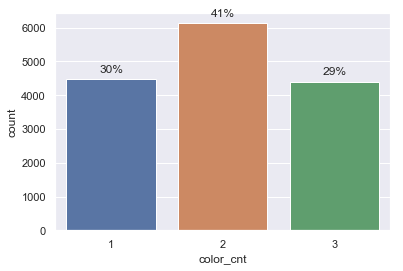

In [270]:
ax= sns.countplot(train['color_cnt'])
for p in ax.patches:
    ax.annotate('{:.0f}%'.format(100*p.get_height()/total_p), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

## Numerical feature analysis <a class='anchor' id='numerical'></a>

In [272]:
train.dtypes

Type                        object
Name                        object
Age                          int64
Breed1                      object
Breed2                      object
Gender                      object
Color1                      object
Color2                      object
Color3                      object
MaturitySize                object
FurLength                   object
Vaccinated                  object
Dewormed                    object
Sterilized                  object
Health                      object
Quantity                     int64
Fee                          int64
State                       object
RescuerID                   object
VideoAmt                     int64
Description                 object
PetID                       object
PhotoAmt                     int64
AdoptionSpeed             category
docsentiment-magnitude     float64
docsentiment-score         float64
top entity                  object
word_count                   int64
Descr_post          

/Users/wandajuan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/wandajuan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/Users/wandajuan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/Users/wandajuan/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses t

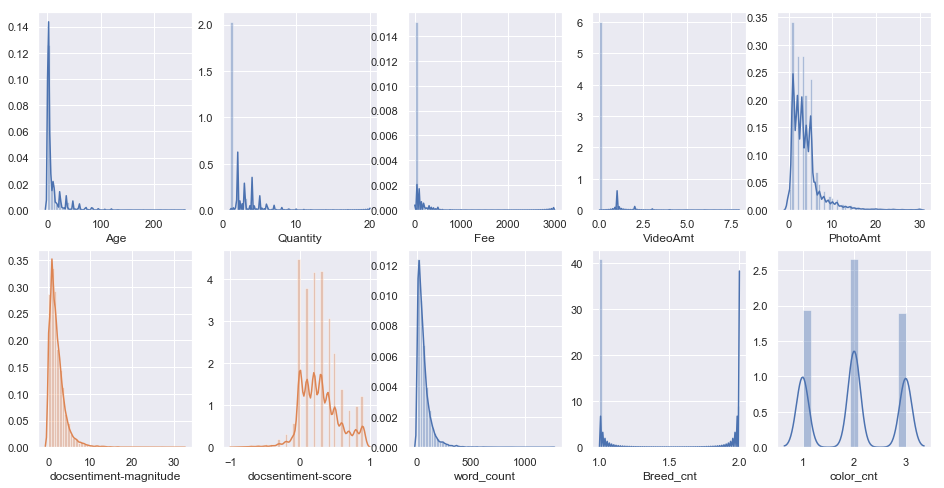

In [271]:
cols = train.columns[(train.dtypes==int)|(train.dtypes==float)]
plt.figure(figsize=(16, 8))
for i, col in enumerate(cols):
    try:
        plt.subplot(len(cols)/4, len(cols)/2,  i+1)
        sns.distplot(train[col])
        #plt.title(col, y=0.98)
    except:
        plt.subplot(len(cols)/4, len(cols)/2,  i+1)
        sns.distplot(train.loc[~train[col].isnull(), col])
        #plt.title(col, y=0.98)
plt.show()

### Multi-variant Analysis <a class='anchor' id='multivariant'></a>

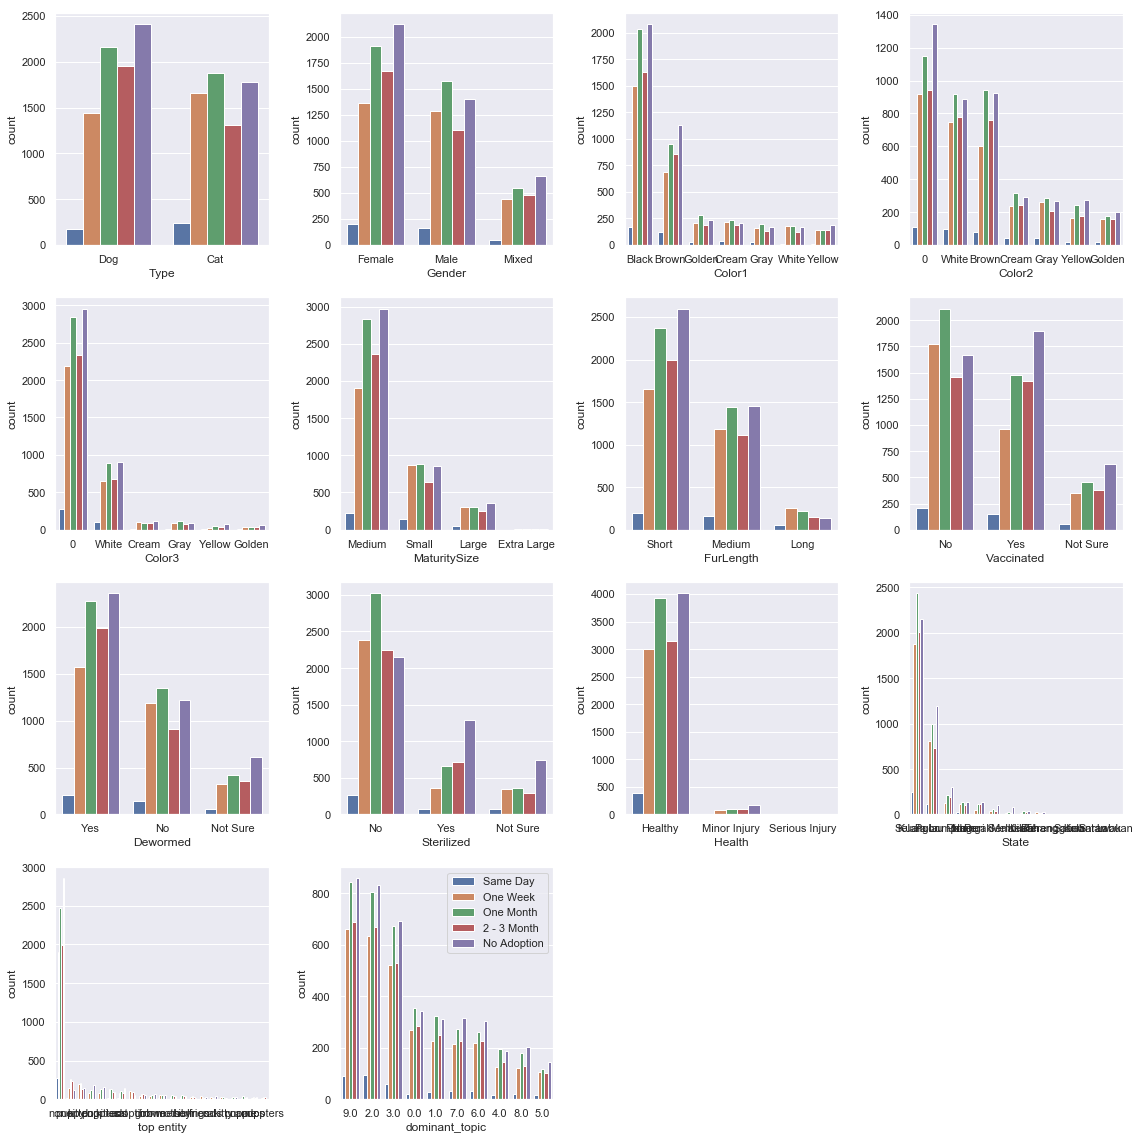

In [316]:
# plot frequency charts only for categorical features that have less than 22 unique values
cols = train.columns[(train.nunique()<22)&(train.dtypes==object)]

plt.figure(figsize=(16, 16))
for i, col in enumerate(cols):
    plt.subplot(4, 4,  i+1)
    ax = sns.countplot(x=col, hue='AdoptionSpeed', data=train, order=train[col].value_counts().index)
    if i == len(cols)-1:
        plt.legend(ncol=1, loc='best')
    else:
        ax.get_legend().set_visible(False)
    plt.tight_layout()
plt.show()

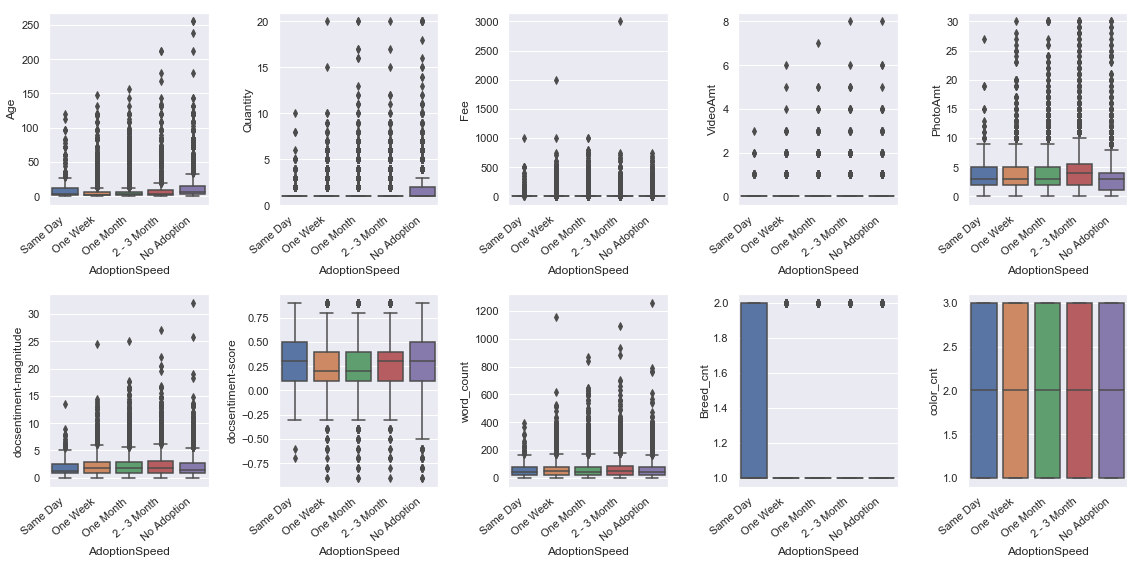

In [286]:
# Numeric
cols = train.columns[(train.dtypes==int)|(train.dtypes==float)]
plt.figure(figsize=(16, 8))
for i, col in enumerate(cols):
    try:
        plt.subplot(len(cols)/4, len(cols)/2,  i+1)
        ax=sns.boxplot(x='AdoptionSpeed', y=col, data=train)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
        plt.tight_layout()
        #plt.title(col, y=0.98)
    except:
        plt.subplot(len(cols)/4, len(cols)/2,  i+1)
        ax=sns.boxplot(x='AdoptionSpeed', y=col, data=train)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
        plt.tight_layout()
        #plt.title(col, y=0.98)
plt.show()

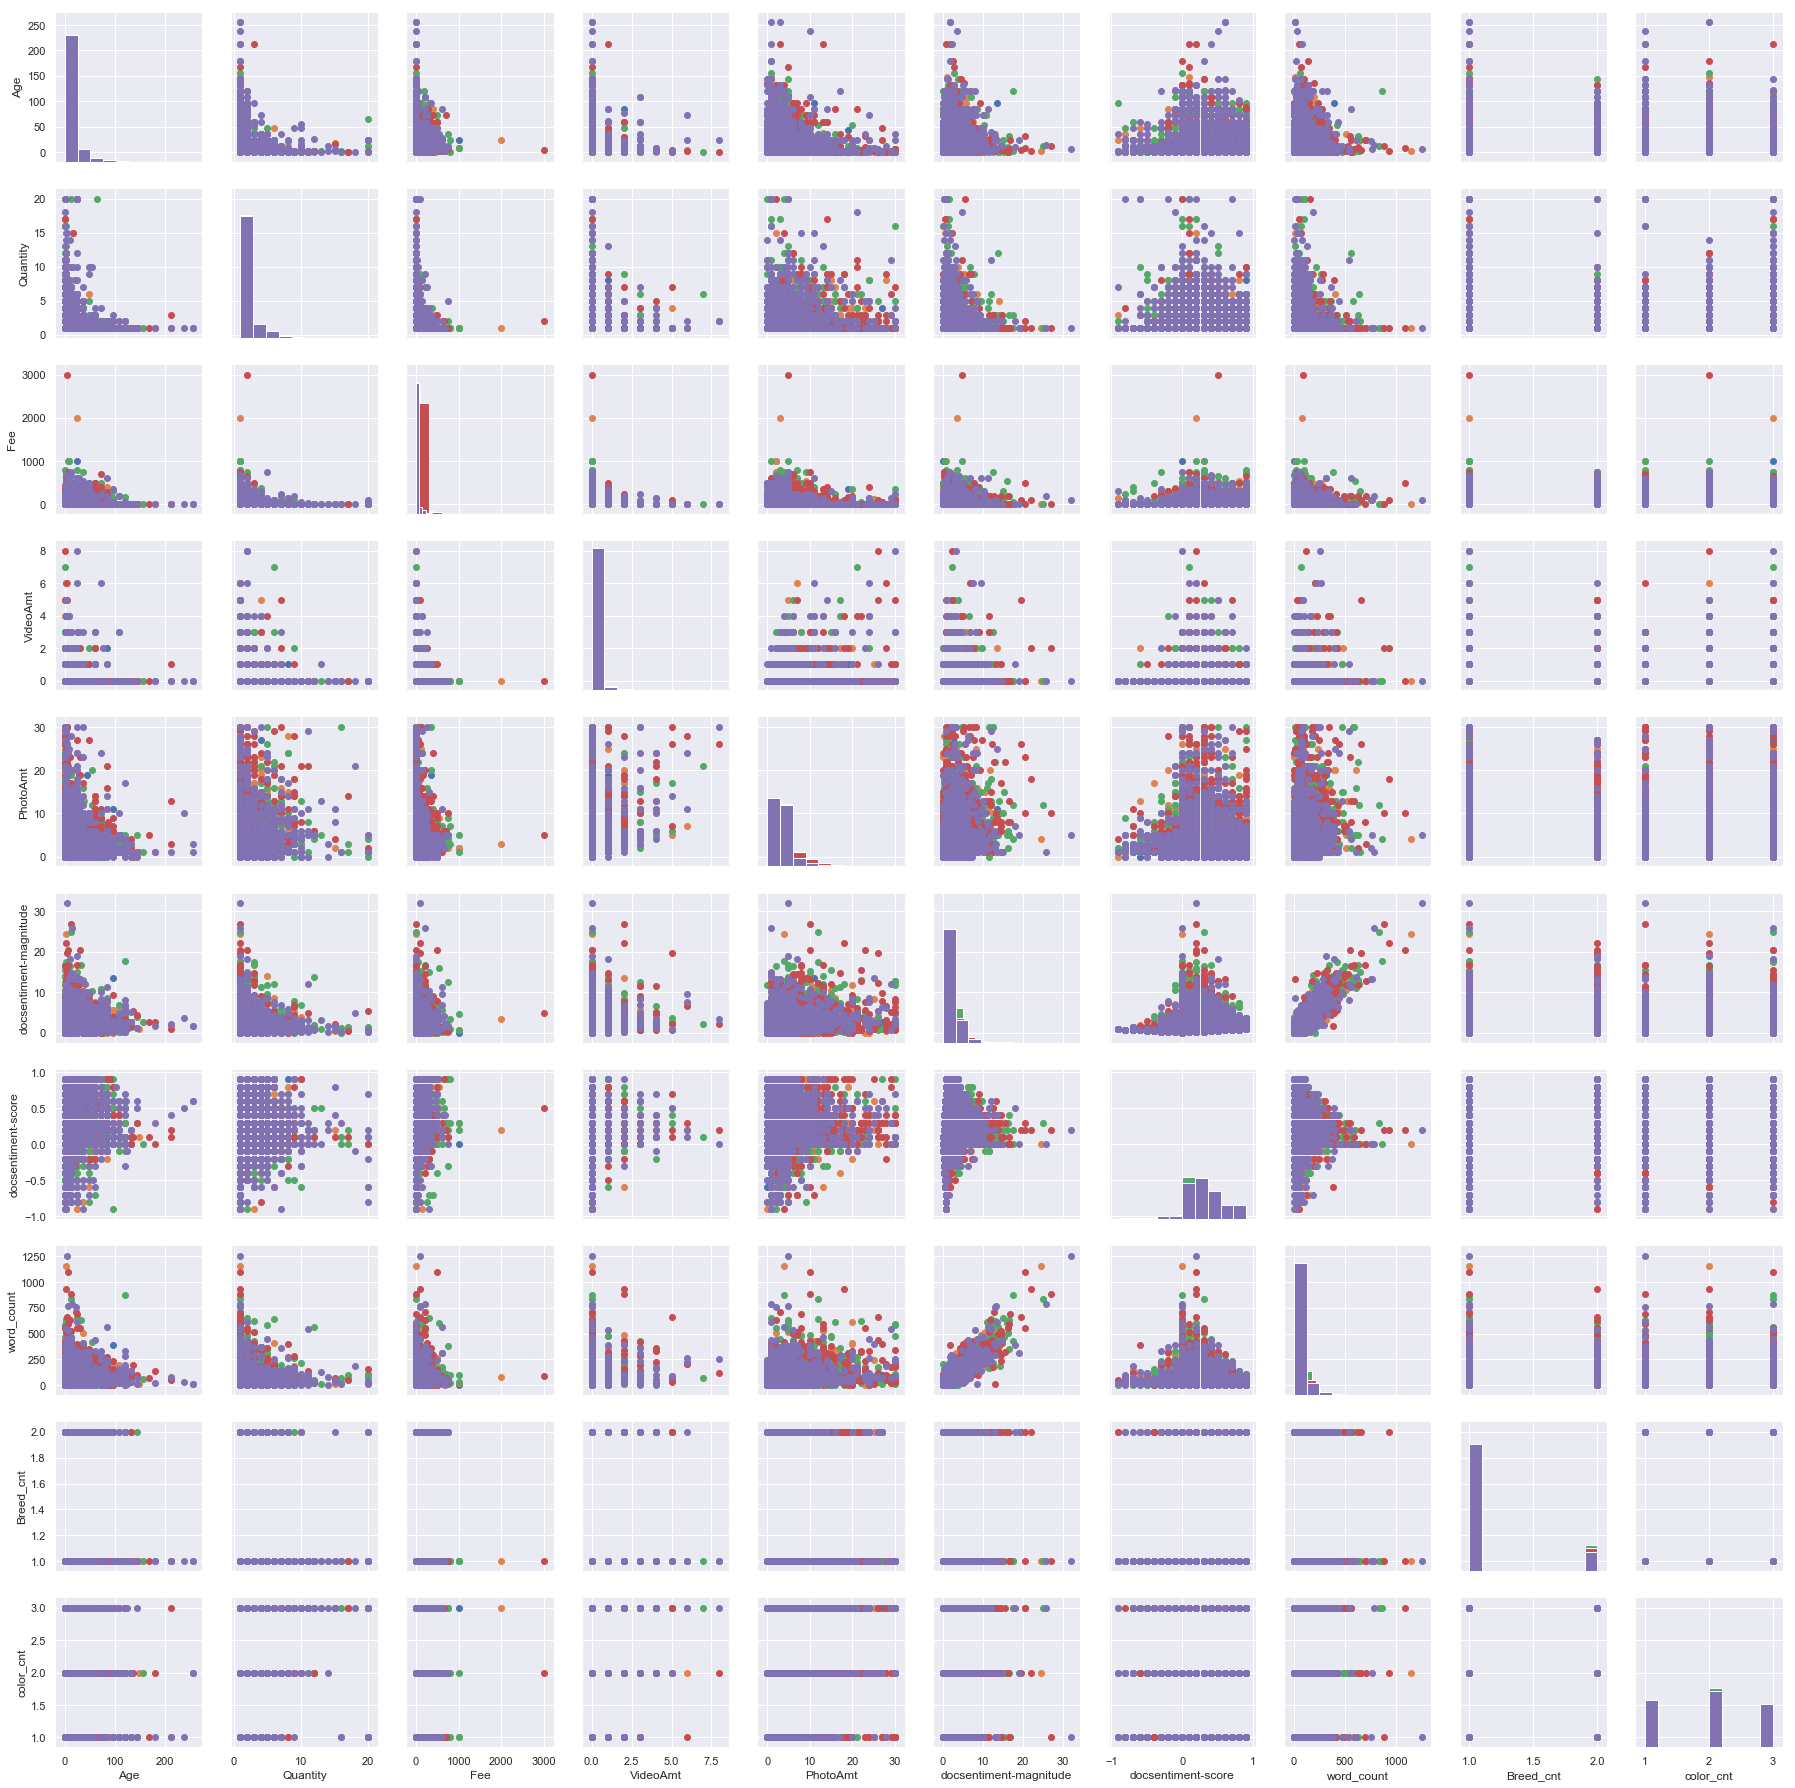

In [325]:
cols=list(train.columns[(train.dtypes==int)|(train.dtypes==float)])+['AdoptionSpeed']
g = sns.PairGrid(train[cols], hue='AdoptionSpeed')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

Interesting that from the above pairplot, **word_count** and **docsentiment-magnitude** have a linear relationship, and this can be explained by the inference that Google sentiment API rates longer descriptions with higher sentiment magnitude. Whereas, **PhotoAmt** and **word_count** have also a rough reverse linear relationship. This counters my intuition, but can be explained by the fact that some people good at writing, and some prefers taking photos.

Older pets have less photos and less word counts. The more pets in a post have less word counts also because the rescuers are too busy taking care of pets. 

## Preprocessing for ML <a class='anchor' id='mlpreprocessing'> </a>

In [328]:
train.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'docsentiment-magnitude', 'docsentiment-score', 'top entity',
       'word_count', 'Descr_post', 'dominant_topic', 'Breed_cnt', 'color_cnt'],
      dtype='object')

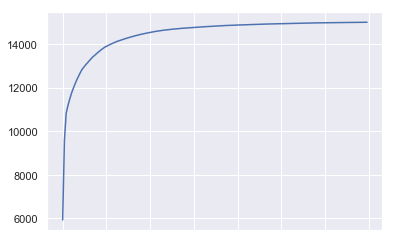

In [353]:
train['Breed1'].value_counts().cumsum().plot()

In [371]:
(train['Breed1'].value_counts().cumsum()/train['Breed1'].value_counts().sum() < 0.9).sum()

19

In [366]:
top20breed = train['Breed1'].value_counts().iloc[:20].index
top20breed

Index(['Mixed Breed', 'Domestic Short Hair', 'Domestic Medium Hair', 'Tabby',
       'Domestic Long Hair', 'Siamese', 'Persian', 'Labrador Retriever',
       'Shih Tzu', 'Poodle', 'Terrier', 'Golden Retriever', 'Calico',
       'German Shepherd Dog', 'American Shorthair', 'Beagle', 'Spitz',
       'Rottweiler', 'Oriental Short Hair', 'Bengal'],
      dtype='object')

In [367]:
train['Breed'] = train['Breed1'].apply(lambda x: x if x in top20breed else 'rare')

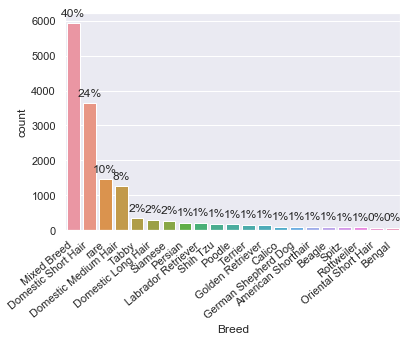

In [369]:
ax = sns.countplot(train['Breed'], order=train['Breed'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
for p in ax.patches:
    ax.annotate('{:.0f}%'.format(100*p.get_height()/total_p), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [372]:
train[['Color1', 'Color2', 'Color3']].drop_duplicates()

,Color1,Color2,Color3
0,Black,White,0
1,Black,Brown,0
2,Brown,White,0
4,Black,0,0
5,Cream,Gray,0
7,Black,Brown,White
8,Gray,0,0
11,Black,Brown,Cream
12,Brown,Cream,Gray
13,Black,Gray,White


In [374]:
set(train['top entity'])

{'adopters',
 'adoption',
 'boy',
 'cat',
 'cats',
 'dog',
 'friend',
 'girl',
 'home',
 'kitten',
 'kittens',
 'kitty',
 'mother',
 'name',
 'none',
 'owner',
 'pup',
 'puppies',
 'puppy',
 'pups',
 'siblings'}

In [376]:
cat = {'cat', 'cats', 'kitten', 'kittens', 'kitty'}
dog = {'puppy', 'dog', 'puppies', 'pup', 'pups'}


In [380]:
train['top entity'].replace({'cats':'cat', 'kitten':'cat', 'kittens':'cat', 'kitty':'cat',\
                             'puppy':'dog', 'puppies':'dog', 'pup':'dog', 'pups':'dog'}, inplace=True)
train['top entity'].value_counts()

none        9486
dog         1919
cat         1807
adoption     358
girl         238
home         216
owner        210
mother       168
boy          160
siblings     125
friend       123
name          99
adopters      84
Name: top entity, dtype: int64

In [435]:
# feature selection
df = train[['Type', 'Age', 'Breed', 'Breed_cnt', 'Gender', 'Color1', 'color_cnt', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 
       'VideoAmt', 'PhotoAmt', 'AdoptionSpeed',
       'docsentiment-score', 'top entity',
       'word_count', 'dominant_topic']]

### Missing Values <a class='anchor' id='nan'> </a>

In [436]:
df.isnull().sum()

Type                    0
Age                     0
Breed                   0
Breed_cnt               0
Gender                  0
Color1                  0
color_cnt               0
MaturitySize            0
FurLength               0
Vaccinated              0
Dewormed                0
Sterilized              0
Health                  0
Quantity                0
Fee                     0
State                   0
VideoAmt                0
PhotoAmt                0
AdoptionSpeed           0
docsentiment-score    551
top entity              0
word_count              0
dominant_topic         24
dtype: int64

In [437]:
from sklearn.impute import SimpleImputer

# impute numerical features' missing values with mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df.loc[:, 'docsentiment-score'] = imp.fit_transform(df['docsentiment-score'].values.reshape(-1,1))

# impute categorical features' missing vlaues with the most frequent value
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df.loc[:, 'dominant_topic'] = imp.fit_transform(df['dominant_topic'].values.reshape(-1,1))

/Users/wandajuan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/wandajuan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Scaling <a class='anchor' id='scaling'></a>

In [438]:
df.describe()

,Age,Breed_cnt,color_cnt,Quantity,Fee,VideoAmt,PhotoAmt,docsentiment-score,word_count
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,10.452078,1.181151,1.994531,1.576069,21.259988,0.056760,3.889215,0.280951,62.953645
std,18.155790,0.385156,0.768734,1.472477,78.414548,0.346185,3.487810,0.271632,69.298493
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-0.900000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.100000,21.000000
50%,3.000000,1.000000,2.000000,1.000000,0.000000,0.000000,3.000000,0.280951,44.000000
75%,12.000000,1.000000,3.000000,1.000000,0.000000,0.000000,5.000000,0.400000,81.000000
max,255.000000,2.000000,3.000000,20.000000,3000.000000,8.000000,30.000000,0.900000,1257.000000


In [439]:
df.columns[(df.dtypes==int)|(df.dtypes==float)]

Index(['Age', 'Breed_cnt', 'color_cnt', 'Quantity', 'Fee', 'VideoAmt',
       'PhotoAmt', 'docsentiment-score', 'word_count'],
      dtype='object')

In [440]:
# scale numeric values to (-1, 1) except for docsentiment-score
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

cols = ['Age', 'Breed_cnt', 'color_cnt', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'word_count']
for col in cols:
    df.loc[:, col] = scaler.fit_transform(df.loc[:, col].values.reshape(-1,1))

/Users/wandajuan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/wandajuan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/wandajuan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [441]:
df.describe()

,Age,Breed_cnt,color_cnt,Quantity,Fee,VideoAmt,PhotoAmt,docsentiment-score,word_count
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,-0.918023,-0.637698,-0.005469,-0.939361,-0.985827,-0.985810,-0.740719,0.280951,-0.899835
std,0.142398,0.770313,0.768734,0.154998,0.052276,0.086546,0.232521,0.271632,0.110260
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.900000,-1.000000
25%,-0.984314,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.866667,0.100000,-0.966587
50%,-0.976471,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-0.800000,0.280951,-0.929992
75%,-0.905882,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-0.666667,0.400000,-0.871122
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.900000,1.000000


### String2Index - encoding<a class='anchor' id='encoding'></a>

In [442]:
df.describe(include=['O'])

,Type,Breed,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,State,top entity,dominant_topic
count,14993,14993,14993,14993,14993,14993,14993,14993,14993,14993,14993,14993,14993
unique,2,21,3,7,4,3,3,3,3,3,14,13,10
top,Dog,Mixed Breed,Female,Black,Medium,Short,No,Yes,No,Healthy,Selangor,none,9.0
freq,8132,5929,7277,7427,10305,8808,7227,8397,10077,14478,8714,9486,3167


In [454]:
cols = set(df.columns) - {'AdoptionSpeed'}

In [458]:
# OneHotEncoder
cols = df.columns[df.dtypes==object]

df = pd.get_dummies(df, columns=list(cols))
df.head()

,Age,Breed_cnt,color_cnt,Quantity,Fee,VideoAmt,PhotoAmt,AdoptionSpeed,docsentiment-score,word_count,Type_Cat,Type_Dog,Breed_American Shorthair,Breed_Beagle,Breed_Bengal,Breed_Calico,Breed_Domestic Long Hair,Breed_Domestic Medium Hair,Breed_Domestic Short Hair,Breed_German Shepherd Dog,Breed_Golden Retriever,Breed_Labrador Retriever,Breed_Mixed Breed,Breed_Oriental Short Hair,Breed_Persian,Breed_Poodle,Breed_Rottweiler,Breed_Shih Tzu,Breed_Siamese,Breed_Spitz,Breed_Tabby,Breed_Terrier,Breed_rare,Gender_Female,Gender_Male,Gender_Mixed,Color1_Black,Color1_Brown,Color1_Cream,Color1_Golden,Color1_Gray,Color1_White,Color1_Yellow,MaturitySize_Extra Large,MaturitySize_Large,MaturitySize_Medium,MaturitySize_Small,FurLength_Long,FurLength_Medium,FurLength_Short,Vaccinated_No,Vaccinated_Not Sure,Vaccinated_Yes,Dewormed_No,Dewormed_Not Sure,Dewormed_Yes,Sterilized_No,Sterilized_Not Sure,Sterilized_Yes,Health_Healthy,Health_Minor Injury,Health_Serious Injury,State_Johor,State_Kedah,State_Kelantan,State_Kuala Lumpur,State_Labuan,State_Melaka,State_Negeri Sembilan,State_Pahang,State_Perak,State_Pulau Pinang,State_Sabah,State_Sarawak,State_Selangor,State_Terengganu,top entity_adopters,top entity_adoption,top entity_boy,top entity_cat,top entity_dog,top entity_friend,top entity_girl,top entity_home,top entity_mother,top entity_name,top entity_none,top entity_owner,top entity_siblings,dominant_topic_0.0,dominant_topic_1.0,dominant_topic_2.0,dominant_topic_3.0,dominant_topic_4.0,dominant_topic_5.0,dominant_topic_6.0,dominant_topic_7.0,dominant_topic_8.0,dominant_topic_9.0
0,-0.976471,-1.0,0.0,-1.0,-0.933333,-1.0,-0.933333,One Month,0.3,-0.890215,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,-0.992157,-1.0,0.0,-1.0,-1.000000,-1.0,-0.866667,Same Day,-0.2,-0.963405,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2,-0.992157,-1.0,0.0,-1.0,-1.000000,-1.0,-0.533333,2 - 3 Month,0.2,-0.890215,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,-0.968627,-1.0,0.0,-1.0,-0.900000,-1.0,-0.466667,One Month,0.9,-0.960223,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
4,-0.992157,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.800000,One Month,0.6,-0.871122,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [459]:
# drop Type_Dog
df.drop('Type_Dog', axis=1, inplace=True)



In [3]:
# df.to_csv('df.csv')
df = pd.read_csv('df.csv')

# prepare X, y
X = df.drop('AdoptionSpeed', axis=1)
y = df['AdoptionSpeed']

In [4]:
X

,Unnamed: 0,Age,Breed_cnt,color_cnt,Quantity,Fee,VideoAmt,PhotoAmt,docsentiment-score,word_count,Type_Cat,Breed_American Shorthair,Breed_Beagle,Breed_Bengal,Breed_Calico,Breed_Domestic Long Hair,Breed_Domestic Medium Hair,Breed_Domestic Short Hair,Breed_German Shepherd Dog,Breed_Golden Retriever,Breed_Labrador Retriever,Breed_Mixed Breed,Breed_Oriental Short Hair,Breed_Persian,Breed_Poodle,Breed_Rottweiler,Breed_Shih Tzu,Breed_Siamese,Breed_Spitz,Breed_Tabby,Breed_Terrier,Breed_rare,Gender_Female,Gender_Male,Gender_Mixed,Color1_Black,Color1_Brown,Color1_Cream,Color1_Golden,Color1_Gray,Color1_White,Color1_Yellow,MaturitySize_Extra Large,MaturitySize_Large,MaturitySize_Medium,MaturitySize_Small,FurLength_Long,FurLength_Medium,FurLength_Short,Vaccinated_No,Vaccinated_Not Sure,Vaccinated_Yes,Dewormed_No,Dewormed_Not Sure,Dewormed_Yes,Sterilized_No,Sterilized_Not Sure,Sterilized_Yes,Health_Healthy,Health_Minor Injury,Health_Serious Injury,State_Johor,State_Kedah,State_Kelantan,State_Kuala Lumpur,State_Labuan,State_Melaka,State_Negeri Sembilan,State_Pahang,State_Perak,State_Pulau Pinang,State_Sabah,State_Sarawak,State_Selangor,State_Terengganu,top entity_adopters,top entity_adoption,top entity_boy,top entity_cat,top entity_dog,top entity_friend,top entity_girl,top entity_home,top entity_mother,top entity_name,top entity_none,top entity_owner,top entity_siblings,dominant_topic_0.0,dominant_topic_1.0,dominant_topic_2.0,dominant_topic_3.0,dominant_topic_4.0,dominant_topic_5.0,dominant_topic_6.0,dominant_topic_7.0,dominant_topic_8.0,dominant_topic_9.0
0,0,-0.976471,-1.0,0.0,-1.000000,-0.933333,-1.00,-0.933333,0.300000,-0.890215,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,1,-0.992157,-1.0,0.0,-1.000000,-1.000000,-1.00,-0.866667,-0.200000,-0.963405,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2,2,-0.992157,-1.0,0.0,-1.000000,-1.000000,-1.00,-0.533333,0.200000,-0.890215,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,3,-0.968627,-1.0,0.0,-1.000000,-0.900000,-1.00,-0.466667,0.900000,-0.960223,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
4,4,-0.992157,-1.0,-1.0,-1.000000,-1.000000,-1.00,-0.800000,0.600000,-0.871122,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5,5,-0.976471,-1.0,0.0,-1.000000,-1.000000,-1.00,-0.866667,0.000000,-0.971360,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,6,-0.905882,-1.0,-1.0,-1.000000,-0.800000,-1.00,-0.800000,0.200000,-0.875895,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
7,7,-1.000000,-1.0,1.0,-0.473684,-1.000000,-1.00,-0.400000,0.100000,-0.968178,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
8,8,-0.984314,-1.0,-1.0,-1.000000,-1.000000,-1.00,-0.600000,0.100000,-0.979316,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
9,9,-0.905882,-1.0,0.0,-1.000000,-1.000000,-1.00,-0.866667,0.200000,-0.928401,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,

In [5]:
y

0          One Month
1           Same Day
2        2 - 3 Month
3          One Month
4          One Month
5          One Month
6           One Week
7        2 - 3 Month
8           One Week
9        No Adoption
10          One Week
11          One Week
12         One Month
13          One Week
14         One Month
15       No Adoption
16       2 - 3 Month
17       No Adoption
18         One Month
19       No Adoption
20         One Month
21       No Adoption
22       No Adoption
23       No Adoption
24          One Week
25         One Month
26          One Week
27         One Month
28       2 - 3 Month
29         One Month
            ...     
14963       One Week
14964    No Adoption
14965       One Week
14966      One Month
14967       One Week
14968    No Adoption
14969    No Adoption
14970    2 - 3 Month
14971    2 - 3 Month
14972       One Week
14973      One Month
14974      One Month
14975    No Adoption
14976    2 - 3 Month
14977    No Adoption
14978    No Adoption
14979    No A

## Model Selection<a class='anchor' id='model'></a>

In [472]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import cohen_kappa_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, shuffle=True)

def get_score(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def print_score(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    train_acc = clf.score(X_train, y_train)
    train_score = get_score(y_train, clf.predict(X_train))
    test_acc = clf.score(X_test, y_test)
    test_score = get_score(y_test, clf.predict(X_test))
    print('Model: {}'.format(clf))
    print('train accuracy: {0:.4f}'.format(train_acc))
    print('train score: {0:.4f}'.format(train_score))
    print('test accuracy: {0:.4f}'.format(test_acc))
    print('test score: {0:.4f}'.format(test_score))

In [470]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
#dtree.fit(X_train, y_train)
#dtree.score(X_train, y_train), dtree.score(X_test, y_test), get_score(y_test, dtree.predict(X_test))

print_score(dtree, X_train, y_train, X_test, y_test)

Model: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
train accuracy:0.9994
train score:0.9991
test accuracy:0.3451
test score:0.1423


In [473]:
from sklearn.svm import SVC

svc = SVC(kernel='linear', C=1)
print_score(svc, X_train, y_train, X_test, y_test)

svc = SVC(kernel='rbf', C=1)
print_score(svc, X_train, y_train, X_test, y_test)

svc = SVC(kernel='poly', C=1)
print_score(svc, X_train, y_train, X_test, y_test)

svc = SVC(kernel='sigmoid', C=1)
print_score(svc, X_train, y_train, X_test, y_test)


Model: SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
train accuracy: 0.3783
train score: 0.1777
test accuracy: 0.3551
test score: 0.1611


/Users/wandajuan/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Model: SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
train accuracy: 0.3491
train score: 0.1282
test accuracy: 0.3515
test score: 0.1320


/Users/wandajuan/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Model: SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
train accuracy: 0.3015
train score: 0.0476
test accuracy: 0.3068
test score: 0.0507


/Users/wandajuan/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Model: SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
train accuracy: 0.3383
train score: 0.0880
test accuracy: 0.3461
test score: 0.0880


In [475]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
print_score(knn, X_train, y_train, X_test, y_test)

Model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
train accuracy: 0.5403
train score: 0.3746
test accuracy: 0.3231
test score: 0.0939


In [476]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
print_score(gnb, X_train, y_train, X_test, y_test)

Model: GaussianNB(priors=None, var_smoothing=1e-09)
train accuracy: 0.0799
train score: 0.0200
test accuracy: 0.0720
test score: 0.0206


In [477]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=10, criterion='entropy')
print_score(rfc, X_train, y_train, X_test, y_test)

Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
train accuracy: 0.9852
train score: 0.9821
test accuracy: 0.3695
test score: 0.1444


In [478]:
import xgboost as xgb

xgbclf = xgb.XGBClassifier(objective='multi:softprob', learning_rate=0.1, n_estimator=500)
print_score(xgbclf, X_train, y_train, X_test, y_test)

Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimator=500,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)
train accuracy: 0.4496
train score: 0.2925
test accuracy: 0.3945
test score: 0.2076


## Grid Search <a class='anchor' id='grid'></a>
So far I have tried several models, and **RandomForestClassifier** has the leading performance. I am going to fine tune the hyperparameters in the hope to increase model performance.

## Predict on test dataset

In [ ]:
with ZipFile('test.zip') as myzip:
    print(myzip.printdir())
    with myzip.open('test.csv') as myfile:
        test = pd.read_csv(myfile)